<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Imports

In [1]:
import pandas as pd
import numpy as np
import operator
import sys
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [2]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [4]:
# Companies description
desc_df = pd.read_csv('../notebooks/content/constituents.csv')
print('\nCompanies Details')
print(desc_df.head())

# stocks details
#stocks_df = pd.read_csv('../notebooks/content/stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
stocks_df = pd.read_csv('../notebooks/content/stocks_data/all_stocks_5yr.csv')#, parse_dates=['date'])
print('\nCompanies Stocks')
print(stocks_df.head())


Companies Details
  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology

Companies Stocks
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


# Preprocess

In [6]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in desc_df[['Symbol', 'Name']].values}
companies_sector = {symbol:sector for symbol, sector in desc_df[['Symbol', 'Sector']].values}

# get all companies symbols
symbols = stocks_df['Name'].values
dates = set(stocks_df['date'].values)
dates = sorted(dates)

# store each individual date and all it's stocks
dates_dictionary = {date:{} for date in dates}

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [7]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

['MCO', 'MNST', 'SPGI', 'JNPR', 'AAL', 'BBY', 'INTU', 'SRCL', 'SCHW', 'MCHP', 'FLR', 'CL', 'ILMN', 'PVH', 'FB', 'M', 'IRM', 'VAR', 'DAL', 'BA', 'IT', 'BAC', 'EXC', 'ETR', 'XRX', 'O', 'LEN', 'LB', 'KLAC', 'PWR', 'RJF', 'HUM', 'C', 'VFC', 'EL', 'GLW', 'DHI', 'NEM', 'AEE', 'RMD', 'PG', 'RHT', 'RHI', 'MAS', 'EFX', 'DPS', 'IVZ', 'KSU', 'AES', 'NFLX', 'AXP', 'SIG', 'MU', 'TDG', 'RF', 'HIG', 'FDX', 'VZ', 'IDXX', 'PNC', 'T', 'LUK', 'ABBV', 'TRV', 'DVA', 'KMI', 'CTSH', 'CRM', 'FCX', 'ADM', 'PFE', 'CTAS', 'AMG', 'EQT', 'CCL', 'DGX', 'AKAM', 'NEE', 'GT', 'PEP', 'GPS', 'HCA', 'KO', 'NFX', 'COF', 'PDCO', 'BF.B', 'LEG', 'MET', 'SWK', 'NLSN', 'HRS', 'MDLZ', 'ARE', 'PEG', 'HP', 'CMS', 'ICE', 'DRI', 'MYL', 'SO', 'KMB', 'AJG', 'GRMN', 'DFS', 'BBT', 'CLX', 'PAYX', 'AFL', 'ETN', 'MKC', 'CSCO', 'NRG', 'ANSS', 'UAA', 'NI', 'KORS', 'K', 'TIF', 'UTX', 'BRK.B', 'DLR', 'F', 'GE', 'NVDA', 'NWL', 'EMR', 'A', 'ES', 'AIZ', 'PPL', 'NKE', 'JEC', 'AEP', 'DTE', 'SEE', 'ED', 'ABT', 'WY', 'HSIC', 'WU', 'PCG', 'RTN', 'QCO

# Train Word Embeddings

In [9]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]

<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]
<ipython-input-10-896125142fcc>:15: DeprecationWarning: Call to d

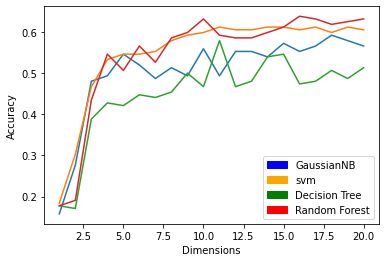

In [10]:
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
counter = []
classifier1_array = []
classifier2_array = []
classifier3_array = []
classifier4_array = []

# test accuracy at various number of dimensions
for j in range(1,21):
    model = Word2Vec(stocks_w2v_data, min_count=1, size=j)
    words = list(model.wv.vocab)
    X = model[model.wv.vocab]
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    # split data for cross validation
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    # predict sectors using GaussianNB, SVM, DecisionTreeClassifier and RandomForestClassifier
    model1 = GaussianNB()
    model1.fit(X_train, Y_train)
    preds1 = model1.predict(X_test)
    
    model2 = svm.SVC()
    model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)
    
    model3 = tree.DecisionTreeClassifier()
    model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)
    
    model4 = RandomForestClassifier()
    model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)
    
    classifier1_array.append(accuracy_score(Y_test, preds1))
    classifier2_array.append(accuracy_score(Y_test, preds2))
    classifier3_array.append(accuracy_score(Y_test, preds3))
    classifier4_array.append(accuracy_score(Y_test, preds4))
    
    counter.append(j)

np.set_printoptions(threshold=sys.maxsize)

pyplot.plot(counter,classifier1_array)
pyplot.plot(counter,classifier2_array)
pyplot.plot(counter,classifier3_array)
pyplot.plot(counter,classifier4_array)
pyplot.ylabel('Accuracy')
pyplot.xlabel('Dimensions')
gnb_patch=mpatches.Patch(color='blue', label='GaussianNB')
svm_patch=mpatches.Patch(color='orange', label='svm')
dtc_patch=mpatches.Patch(color='green', label='Decision Tree')
rfc_patch=mpatches.Patch(color='red', label='Random Forest')
pyplot.legend(handles=[gnb_patch,svm_patch, dtc_patch, rfc_patch], loc='best')
pyplot.show()

In [24]:
# confusion matrix function
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = pyplot.subplots(figsize=(20, 15)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(230, 30, n=9),
        ax=ax,
        annot_kws={"fontsize":20}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    pyplot.ylabel('Actual', fontsize = 36)
    pyplot.xlabel('Predicted', fontsize = 36)
    #ax.set_title('Confusion Matrix', fontsize = 40, y = -.02)
    ax.set_xticklabels(class_names, fontsize=28, rotation=90)
    ax.set_yticklabels(class_names, rotation=0, fontsize = 28)
    b, t = pyplot.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    pyplot.ylim(b, t) # update the ylim(bottom, top) values
    pyplot.show()

In [12]:
# recreate model with 4 dimensions(this is the model that will be used for the rest of the code)
model = Word2Vec(stocks_w2v_data, min_count=1, size=4)
words = list(model.wv.vocab)
X = model[model.wv.vocab]
Y = list()
for word in words:
    Y.append(companies_sector[word])

# split data set for cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

<ipython-input-12-68013c85427e>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


Accuracy is  0.5131578947368421


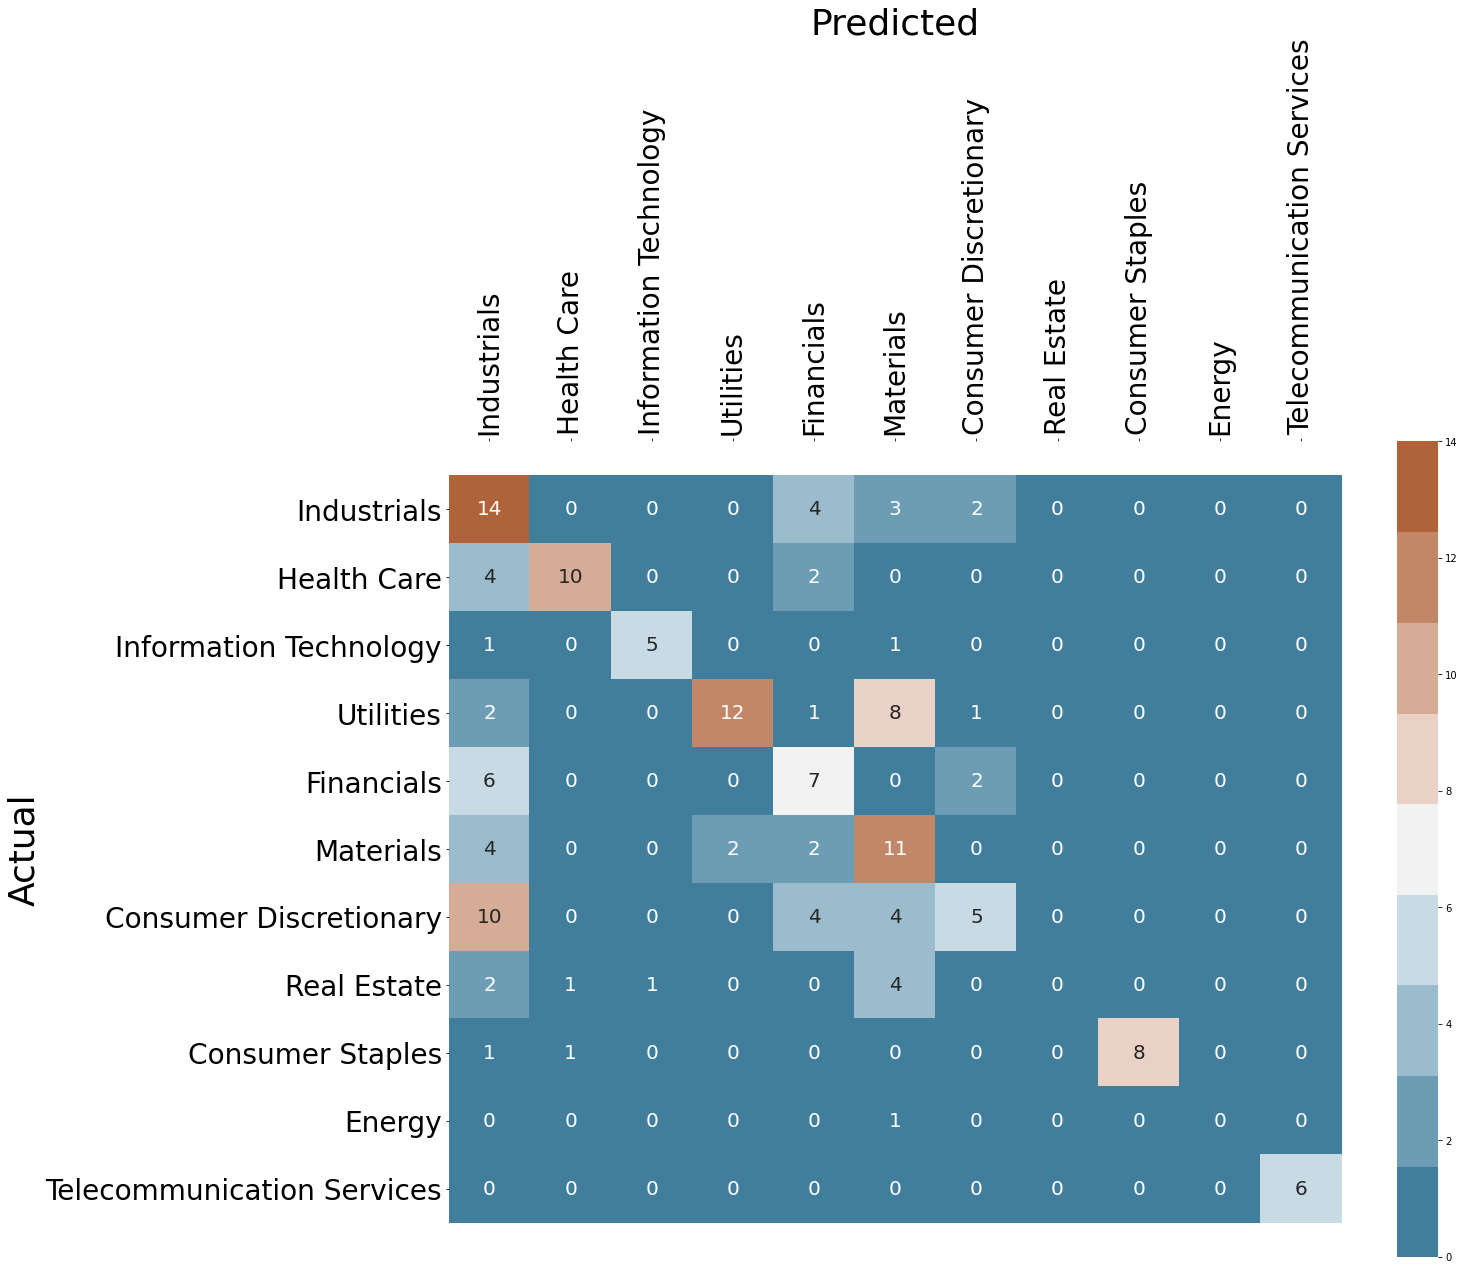

In [25]:
# plot confusion matrix for SVM classifier at 4 dimensions
model2.fit(X_train, Y_train)
preds2= model2.predict(X_test)
acc = accuracy_score(Y_test, preds2)
print("Accuracy is ", acc)
plot_cm(Y_test,preds2,labels)

<ipython-input-17-4a418c2826a4>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  array1X.append((model[model.wv.vocab])[d,0])
<ipython-input-17-4a418c2826a4>:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  array1Y.append((model[model.wv.vocab])[d,1])


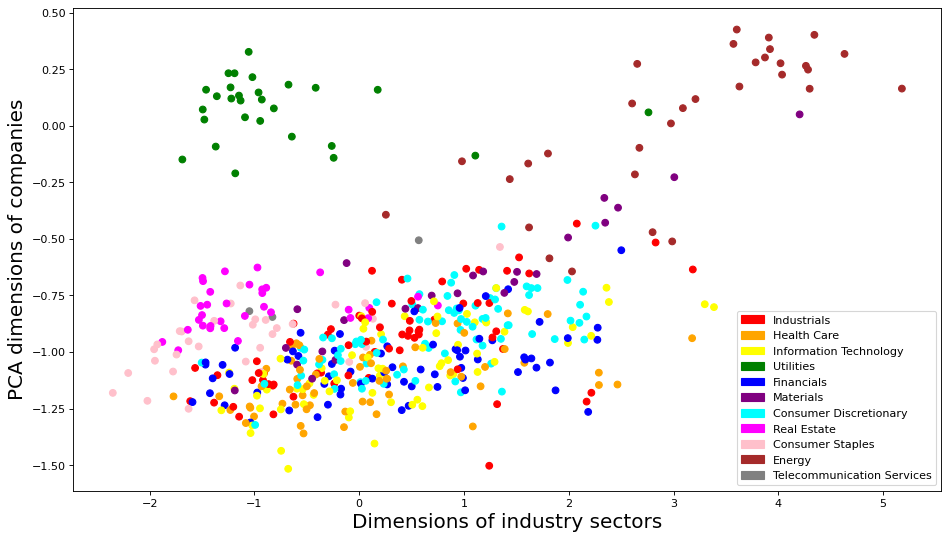

<ipython-input-17-4a418c2826a4>:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  array2X.append((model[model.wv.vocab])[f,2])
<ipython-input-17-4a418c2826a4>:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  array2Y.append((model[model.wv.vocab])[f,3])


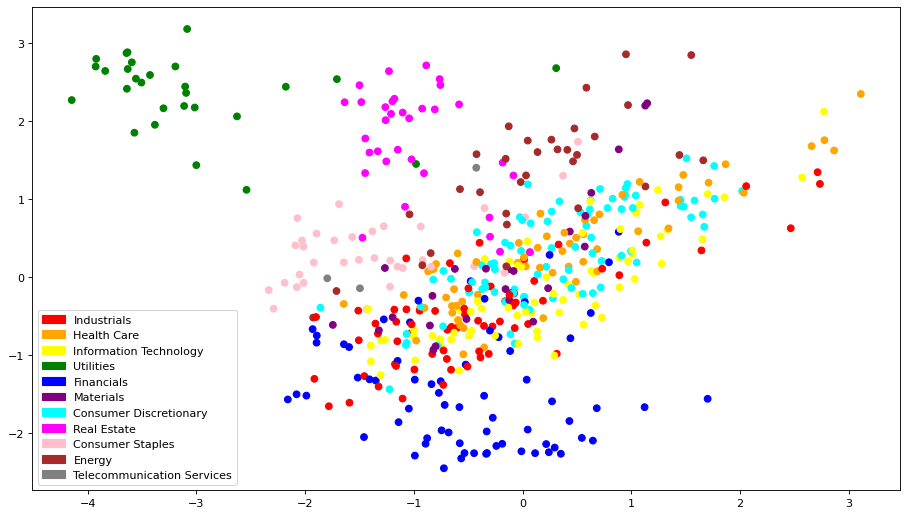

In [17]:
array1X = []
array1Y = []
array2X = []
array2Y = []

# color code by sector
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in words]

# legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')

# graph dimensions 1 & 2
for d in range(0,505):
    array1X.append((model[model.wv.vocab])[d,0])
    array1Y.append((model[model.wv.vocab])[d,1])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array1X[:], array1Y[:], c=cvec)
pyplot.xlabel('Dimensions of industry sectors', fontsize=18)
pyplot.ylabel('PCA dimensions of companies', fontsize=18) 
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

# graph dimensions 3 & 4
for f in range(0,505):
    array2X.append((model[model.wv.vocab])[f,2])
    array2Y.append((model[model.wv.vocab])[f,3])
pyplot.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(array2X[:], array2Y[:], c=cvec)
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()

In [19]:
words = list(model.wv.vocab)
X = model[model.wv.vocab]

<ipython-input-19-fe201196f604>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


<ipython-input-20-3e022f074e0c>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


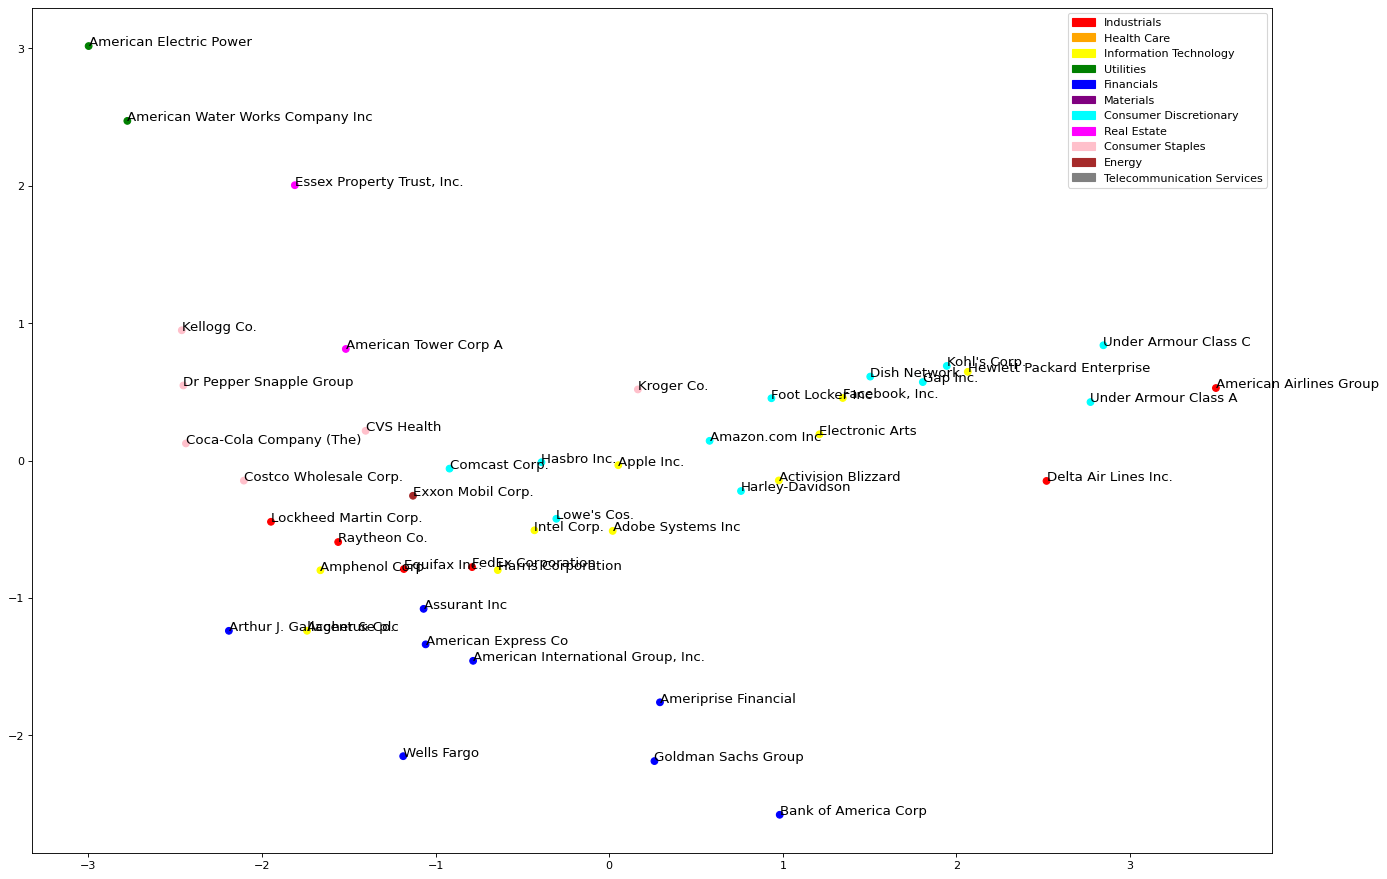

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [20]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=4)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

<ipython-input-21-1739df3933db>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


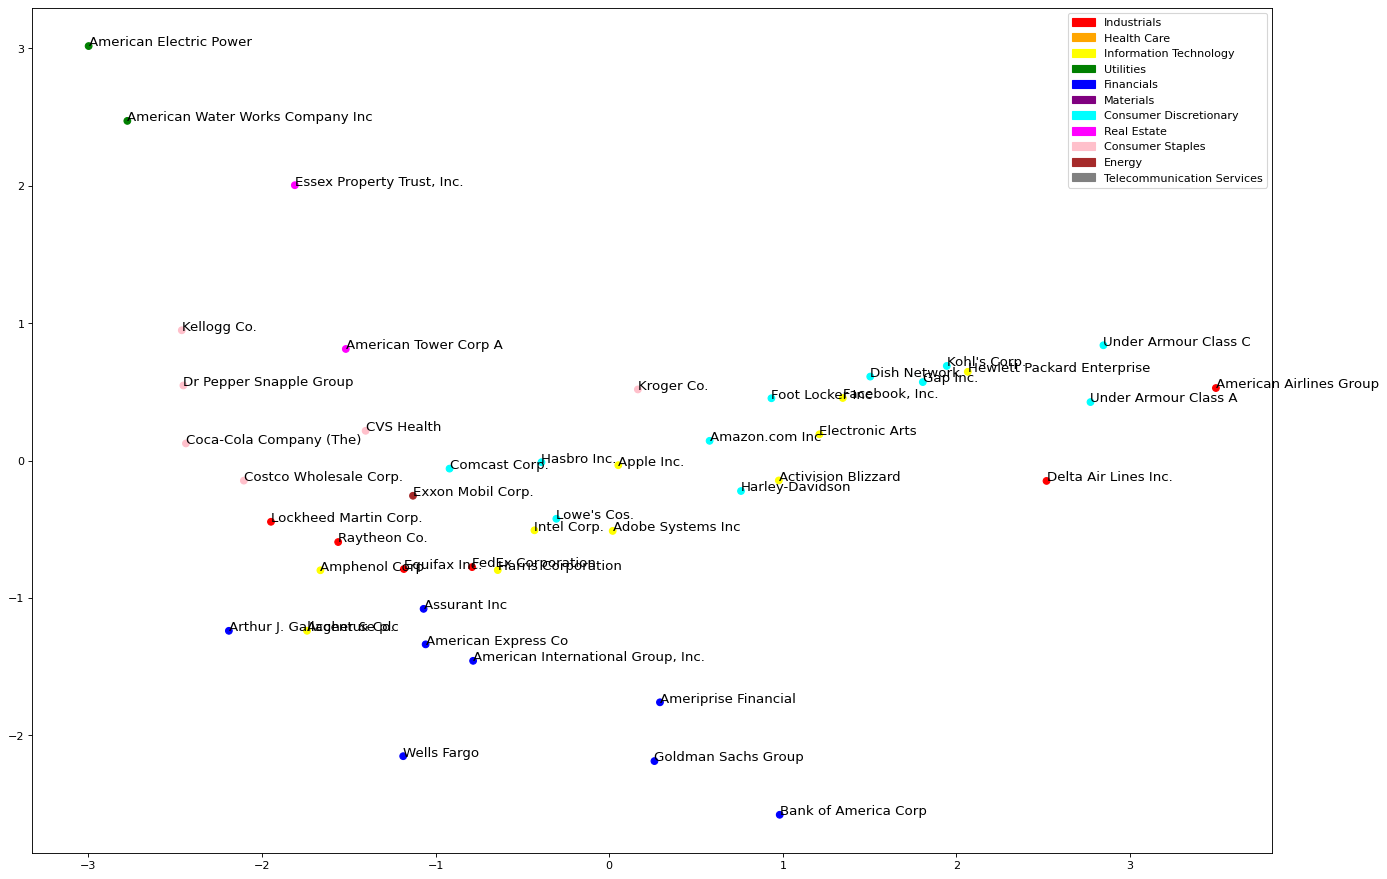

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [21]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=2)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

In [61]:
X

450e+00],
       [ 4.43112314e-01,  1.79453611e+00, -3.46510077e+00,
         1.65039524e-01],
       [-5.69501370e-02, -2.28523403e-01, -8.45506012e-01,
        -1.10636282e+00],
       [-9.12156045e-01,  9.91187274e-01,  3.57158065e-01,
        -3.35981667e-01],
       [-2.73428351e-01,  8.96944344e-01, -2.75360852e-01,
        -5.25724888e-01],
       [-5.72565258e-01,  8.63059342e-01, -1.78415775e-01,
        -4.35390741e-01],
       [ 2.81930506e-01,  2.26010251e+00, -1.58591664e+00,
         1.77994996e-01],
       [ 5.90039134e-01, -2.36297324e-01, -7.50837803e-01,
        -1.39236093e+00],
       [ 7.66242981e-01, -2.74462074e-01, -2.18308592e+00,
        -1.28609359e+00],
       [-5.92073917e-01, -1.17751002e+00,  1.94092715e+00,
        -1.95838785e+00],
       [ 3.57319504e-01, -4.05156076e-01, -7.13174522e-01,
        -1.40939736e+00],
       [ 5.16717792e-01, -3.66277754e-01, -1.22350335e+00,
        -1.35214293e+00],
       [-4.43788012e-03, -1.34912872e+00,  4.41495717e-

In [59]:
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
#top_similar = model.similar_by_vector(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: NFLX	Name: Netflix Inc.			Sector: Information Technology
Symbol: AAL	Name: American Airlines Group			Sector: Industrials
Symbol: UAA	Name: Under Armour Class A			Sector: Consumer Discretionary
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: CNC	Name: Centene Corporation			Sector: Health Care
Symbol: CELG	Name: Celgene Corp.			Sector: Health Care
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: MU	Name: Micron Technology			Sector: Information Technology
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: LEN	Name: Lennar Corp.			Sector: Consumer Discretionary
Symbol: UAL	Name: United Continental Holdings			Sector: Industrials
Symbol: DHI	Name: D. R. Horton			Sector: Consumer Discretionary
Symbol

In [62]:
# access vector for one word
print(model['AAL'])

[-2.9156845   1.3464382   2.3512566   0.20924406]


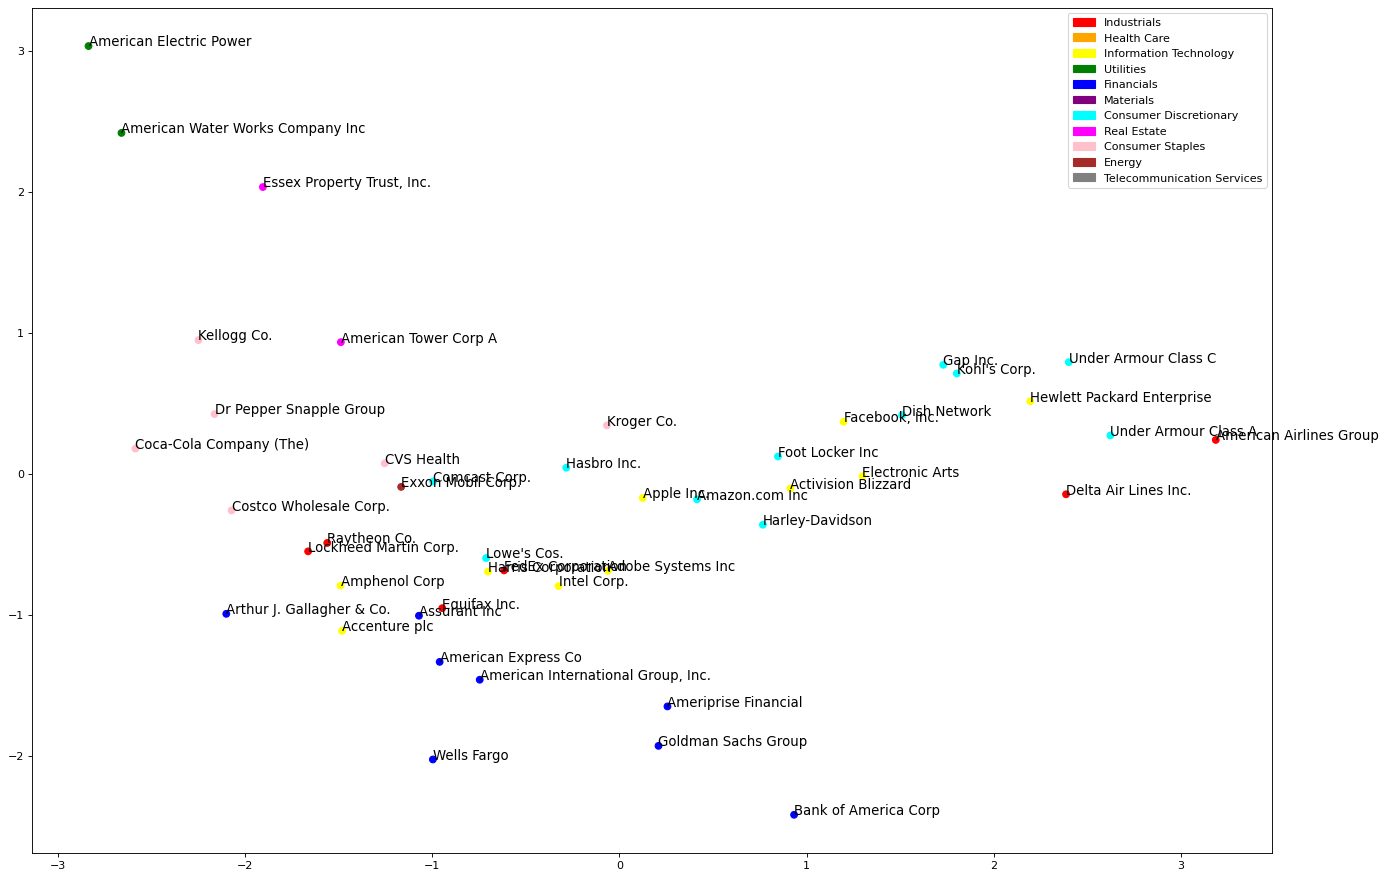

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [50]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=4)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

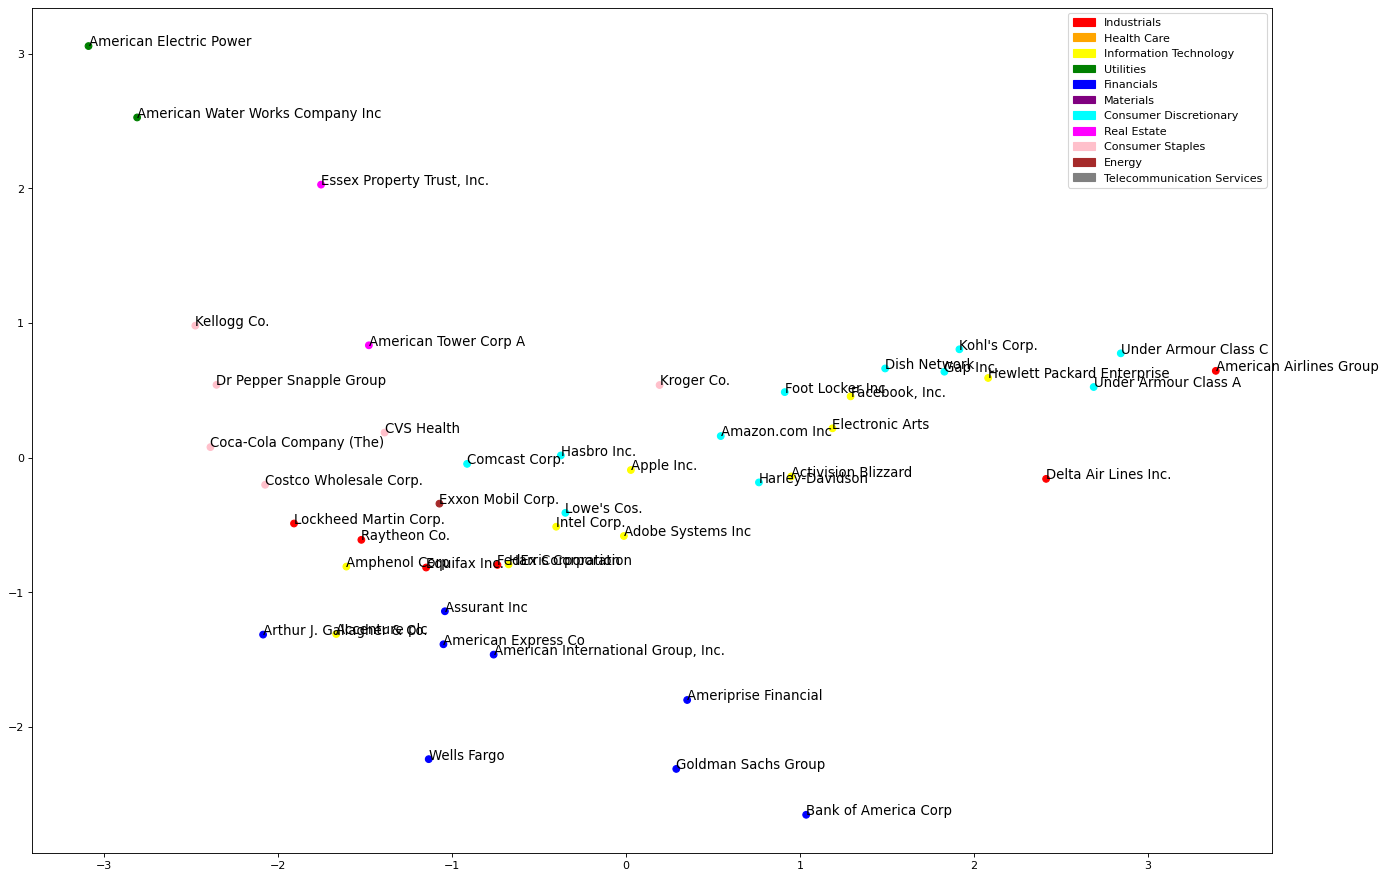

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [63]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=2)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

In [66]:
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
#top_similar = model.similar_by_vector(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: MYL	Name: Mylan N.V.			Sector: Health Care
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: AAL	Name: American Airlines Group			Sector: Industrials
Symbol: LEN	Name: Lennar Corp.			Sector: Consumer Discretionary
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: UAL	Name: United Continental Holdings			Sector: Industrials
Symbol: NFLX	Name: Netflix Inc.			Sector: Information Technology
Symbol: BIIB	Name: Biogen Inc.			Sector: Health Care
Symbol: DHI	Name: D. R. Horton			Sector: Consumer Discretionary
Symbol: PHM	Name: Pulte Homes Inc.			Sector: Consumer Discretionary
Symbol: NCLH	Name: Norwegian Cruise Line			Sector: Consumer Discretionary
Symbol: NVDA	Na

In [67]:
# access vector for one word
print(model['AAL'])

[-2.3085883 -2.5365422 -0.6068273  1.3847815]


In [64]:
print(model.vector_size)

4


In [76]:
model

In [69]:
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

[2.578161  1.5042285]
Matrix W:
 [[-0.31901464 -0.5193395 ]
 [-0.20597298  0.34604055]]


In [70]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.578161  1.5042285]
[0.5404254 0.3153113]
[0.5404254  0.85573673]


In [71]:
pca.components_

array([[-0.31901464, -0.5193395 , -0.03552455,  0.7919938 ],
       [-0.20597298,  0.34604055, -0.90950024,  0.1031505 ]],
      dtype=float32)

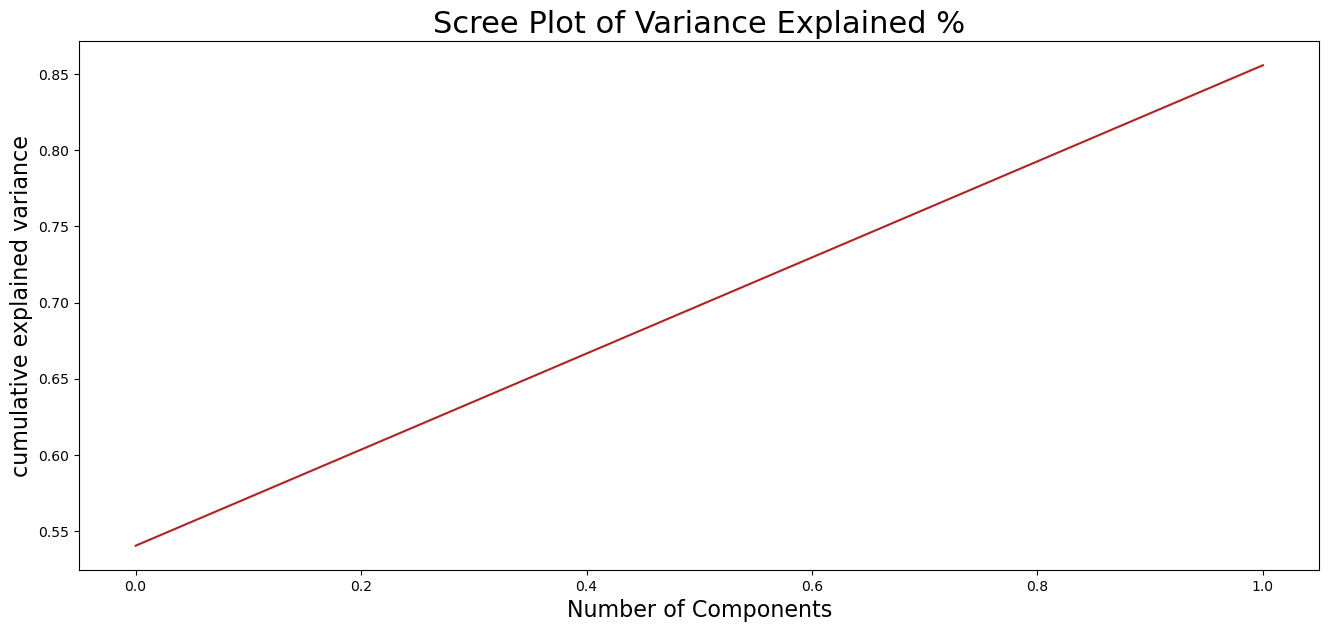

In [72]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
fig, axes = pyplot.subplots(1,1,figsize=(16,7), dpi=100)
pyplot.plot(variance_exp_cumsum, color='firebrick')
pyplot.title('Scree Plot of Variance Explained %', fontsize=22)
pyplot.xlabel('Number of Components', fontsize=16)
pyplot.ylabel('cumulative explained variance', fontsize=16)
pyplot.show()

In [35]:
NUMBER_OF_COMPONENTS = 2
print("Overall")
print(pca.explained_variance_ratio_)
for component in range(NUMBER_OF_COMPONENTS):
    comp = pca.components_[component]
    print("Component %i explains ratio: %.6f" % ((component + 1),pca.explained_variance_ratio_[component]) )
    sorted_index = np.argsort(comp)

Overall
[0.5994994 0.3173974]
Component 1 explains ratio: 0.599499
Component 2 explains ratio: 0.317397


In [37]:
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([59.899998, 91.6     ], dtype=float32)

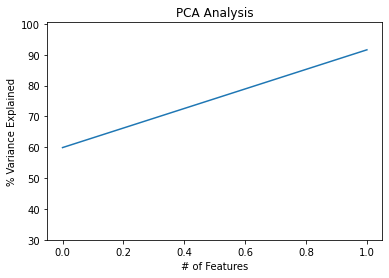

In [38]:
pyplot.ylabel('% Variance Explained')
pyplot.xlabel('# of Features')
pyplot.title('PCA Analysis')
pyplot.ylim(30,100.5)
pyplot.style.context('seaborn-whitegrid')

pyplot.plot(var)